In [9]:
# General Imports
import pandas as pd
import seaborn as sns
from sklearn import tree
from math import ceil
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.feature_selection import f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, accuracy_score, 
                             make_scorer, recall_score, f1_score, precision_score)
import matplotlib.pyplot as plt
import random as rnd
from time import perf_counter as time
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
from preprocessing_utils import drop_features_, fill_nan_values

### The code reads a compressed CSV dataset from a specified file path using pandas. It focuses on preparing the dataset for classification tasks by setting the target variable, removing irrelevant features and providing key insights such as the dataset's shape, information and the count of NULL & unique values per column.
***Tasks***: 
- Reads a compressed CSV dataset using pandas.
- Defines the target variable for either multi-class or binary classification.
- Removes irrelevant features from the dataset.
- Prints the original shape of the dataset.
- Displays dataset information, including data types.
- Prints the number of NULL values per column.
- Prints the number of unique values per column.


In [2]:
dataset_fpath = '../data/BTS1_BTS2_fields_preserved.zip'
nidd_dataset = pd.read_csv(dataset_fpath, compression = 'zip', low_memory=False)

# Attack Type for Multi-Class Classification or Label for Binary Classification
TARGET = 'Label'
DROPPED_TARGET = "Label" if TARGET == "Attack Type" else "Attack Type"

useless_features = ['Attack Tool', DROPPED_TARGET, 'Dport', 'Sport', 'SrcAddr', 'DstAddr',"Unnamed: 0"]
nidd_dataset = nidd_dataset.drop(useless_features, axis=1)
print(f"Original shape of Dataset: {nidd_dataset.shape}")

print(f'\nDataset Information:')
nidd_dataset.info()

# print(f'\nDataset Description:')
# print(nidd_dataset.describe())

print(f'\nNumber of NULL values per column:')
print(nidd_dataset.isnull().sum())

print(f'\nNumber of unique values per column:')
print(nidd_dataset.nunique())

Original shape of Dataset: (1215890, 106)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215890 entries, 0 to 1215889
Columns: 106 entries, SrcId to Label
dtypes: float64(66), int64(24), object(16)
memory usage: 983.3+ MB

Number of NULL values per column:
SrcId             0
Rank              0
StartTime         0
LastTime          0
Trans             0
              ...  
TcpRtt            0
SynAck            0
AckDat            0
TcpOpt       938654
Label             0
Length: 106, dtype: int64

Number of unique values per column:
SrcId             1
Rank         467717
StartTime     32888
LastTime      32828
Trans             1
              ...  
TcpRtt        18745
SynAck         3896
AckDat        23870
TcpOpt            7
Label             2
Length: 106, dtype: int64


### Dropping columns based on specified threshold values
***Tasks***:
- Initializes dictionaries to store dropped features and processing time.
- Drops columns with more than 95% NaN values from the dataset.
- Drops columns with more than 95% zero values from the updated dataset.
- Drops constant columns from the further cleaned dataset.
- Calculates and prints the time taken for the dropping features step.

In [3]:
# Dictionary to store dropped features based on different criteria
features_dropped = {"Nan columns": [], "Zero columns": [], "Constant columns": [], "General columns": useless_features}

# Dictionary to store processing time
preprocessing_d = {"Time <Dropping features based on a threshold `bad` values>": 0.,
                   "Time <Filling NaNs>": 0.,
                   "Time <Encoding categorical features>": 0.,
                   "Time <Feature selection>": 0.,
                   "Time <Model training>": 0.,
                   "Time <Model testing>": 0.,
                   "Time <Cross validation>": 0.,}

# Record the starting time for dropping features based on "bad" values
t0 = time()

# Dropping columns with more than 95% NaN values
threshold_nans = 0.95 * nidd_dataset.shape[0]
columns_Nan_to_drop = nidd_dataset.columns[nidd_dataset.isna().sum() > threshold_nans]
features_dropped["Nan columns"].extend(columns_Nan_to_drop)
nidd_dataset_cleaned_nan = nidd_dataset.drop(columns=columns_Nan_to_drop)
# Alternatively, you can use:
# nidd_dataset_cleaned_nan = nidd_dataset.dropna(thresh=ceil(1 - threshold_nans), axis=1)
print(f"After dropping NaN columns: {nidd_dataset_cleaned_nan.shape}")

# Dropping columns with more than 95% zero values
threshold_zeros = 0.95 * nidd_dataset.shape[0]
zero_counts = nidd_dataset_cleaned_nan.apply(lambda col: (col == 0).sum())
columns_zeros_to_drop = zero_counts[zero_counts > threshold_zeros].index
features_dropped["Zero columns"].extend(columns_zeros_to_drop)
nidd_dataset_cleaned_zeros = nidd_dataset_cleaned_nan.drop(columns_zeros_to_drop, axis=1)
print(f"After dropping NaN & Zero columns: {nidd_dataset_cleaned_zeros.shape}")

# Dropping constant columns
constant_columns = nidd_dataset_cleaned_zeros.columns[nidd_dataset_cleaned_zeros.nunique() == 1]
features_dropped["Constant columns"].extend(constant_columns)
nidd_dataset_cleaned = nidd_dataset_cleaned_zeros.drop(columns=constant_columns)
print(f"After dropping NaN & Zero & Constant columns: {nidd_dataset_cleaned.shape}")

# Record the ending time for dropping features based on "bad" values
t1 = time()

# Calculate and print the time taken for the dropping features step
preprocessing_d["Time <Dropping features based on a threshold `bad` values>"] = t1 - t0
print(f"Time <Dropping features based on a threshold `bad` values>: {preprocessing_d['Time <Dropping features based on a threshold `bad` values>']:.3f} seconds")

# equivalent
# nidd_dataset_cleaned, drop_time = drop_features_(nidd_dataset,[0.95, 0.95], features_dropped)
# preprocessing_d["Time <Dropping features based on a threshold `bad` values>"] = drop_time
# print(f"Time <Dropping features based on a threshold `bad` values>: {preprocessing_d['Time <Dropping features based on a threshold `bad` values>']:.3f} seconds")

After dropping NaN columns: (1215890, 70)
After dropping NaN & Zero columns: (1215890, 55)
After dropping NaN & Zero & Constant columns: (1215890, 51)
Time <Dropping features based on a threshold `bad` values>: 2.694 seconds


### Filling NaN values and Encoding categorical columns using Label Encoder
***Tasks***:

**1. Filling NaN Values:**
   - Identify numeric and categorical columns in the cleaned dataset.
   - Fill NaN values in numeric columns with the mean of each column.
   - Fill NaN values in categorical columns with the mode of each column.
   - Print the time taken for filling NaN values.

**2. Encoding Categorical Features:**
   - Use LabelEncoder to transform categorical columns into numerical representations.
   - Print the time taken for encoding categorical features.



In [4]:
# Record the starting time for filling NaN values
t0 = time()

# Get numeric and categorical columns
numeric_cols = nidd_dataset_cleaned.select_dtypes(include='number').columns
categorical_cols = nidd_dataset_cleaned.select_dtypes(include='object').columns

# Fill NaN values in numeric columns with mean
numeric_cols_mean = nidd_dataset_cleaned[numeric_cols].mean()
nidd_dataset_cleaned[numeric_cols] = nidd_dataset_cleaned[numeric_cols].fillna(numeric_cols_mean)

# Fill NaN values in categorical columns with mode
# iloc[0] is used to get the first element of the series in case there is more than one mode.
categorical_cols_mode = nidd_dataset_cleaned[categorical_cols].mode().iloc[0]
nidd_dataset_cleaned[categorical_cols] = nidd_dataset_cleaned[categorical_cols].fillna(categorical_cols_mode)

# Record the ending time for filling NaN values
t1 = time()
preprocessing_d["Time <Filling NaNs>"] = t1 - t0

# Print the time taken for filling NaN values
print(f"Time <Filling NaNs>: {preprocessing_d['Time <Filling NaNs>']:.3f} seconds")

# equivalent
# nidd_dataset_cleaned, fill_time = fill_nan_values(nidd_dataset_cleaned, method = "mean")
# preprocessing_d["Filling NaNs"] = fill_time
# print(f"Time <Filling NaNs>: {preprocessing_d['Time <Filling NaNs>']:.3f} seconds")

# Record the starting time for encoding categorical features
t0 = time()

# Encoding categorical columns using LabelEncoder
label_encoder = LabelEncoder()
for column in categorical_cols:
    nidd_dataset_cleaned[column] = label_encoder.fit_transform(nidd_dataset_cleaned[column])

# Record the ending time for encoding categorical features
t1 = time()
preprocessing_d["Time <Encoding categorical features>"] = t1 - t0

# Print the time taken for encoding categorical features
print(f"Time <Encoding categorical features>: {preprocessing_d['Time <Encoding categorical features>']:.3f} seconds")

Time <Filling NaNs>: 2.528 seconds
Time <Encoding categorical features>: 1.336 seconds


### Dropping features based on the Pearson Correlation Matrix

***Tasks***:
- Define the target column for correlation analysis (e.g., TARGET).
- Calculate the correlation matrix using the Pearson method.
- Set a correlation threshold for feature selection (e.g., 0.9).
- Identify pairs of features with high correlation.
- Initialize a set to store features to be dropped (avoiding duplicates).
- Iterate through the pairs of highly correlated features.
   - Check if the correlation signs are the same.
   - Keep the feature with the higher absolute correlation with the target variable.
   - Add the selected feature to the set of features to be dropped.
- Drop the identified features with high correlation from the cleaned dataset.
- Update the total preprocessing time for feature selection.
- Print the final shape of the cleaned DataFrame after removing correlated features.
- Visualize the correlation matrix with a heatmap.

Final shape of cleaned DataFrame after removing correlated features based on Pearson method: (1215890, 36)


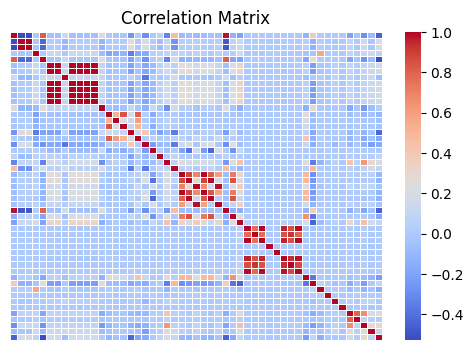

In [6]:
t0 = time()

# Define the target column for correlation analysis
target_col = nidd_dataset_cleaned.columns[-1] # eq: TARGET

# Calculate the correlation matrix using Pearson method
correlation_matrix = nidd_dataset_cleaned.corr(method='pearson')

# Set the correlation threshold for feature selection
corr_threshold = 0.9

# Identify pairs of features with high correlation
high_corr_pairs = correlation_matrix.iloc[:, :-1].abs() > corr_threshold

# Initialize a set to store features to be dropped (avoiding duplicates)
features_to_drop = set()

# Iterate through the pairs of highly correlated features
for feature_on_col in high_corr_pairs.columns:
    for feature_in_row in high_corr_pairs.index[high_corr_pairs[feature_on_col]]:
        if feature_on_col != feature_in_row:  # Avoid comparisons between the same pairs
            # Get the correlation values for each feature against the target variable
            feature_in_row_cor_val = correlation_matrix.loc[feature_in_row, target_col]
            feature_on_col_cor_val = correlation_matrix.loc[feature_on_col, target_col]
            
            # Check if the correlation signs are the same
            same_corellation_sign = feature_in_row_cor_val * feature_on_col_cor_val > 0
            
            # If the signs are the same, keep the feature with the higher absolute correlation
            if same_corellation_sign:
                if abs(feature_in_row_cor_val) > abs(feature_on_col_cor_val):
                    features_to_drop.add(feature_on_col)
                else:
                    features_to_drop.add(feature_in_row)

# Drop the identified features with high correlation
nidd_dataset_filtered = nidd_dataset_cleaned.drop(columns=list(features_to_drop))

t1 = time()

# Update the total preprocessing time for feature selection
preprocessing_d["Time <Feature selection>"] += t1 - t0

# Print the final shape of the cleaned DataFrame after removing correlated features
print(f"Final shape of cleaned DataFrame after removing correlated features based on Pearson method: {nidd_dataset_filtered.shape}")

# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', 
            fmt='.2f', xticklabels=False, yticklabels=False,
            linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

### ANOVA F-scores are calculated for each feature and a DataFrame is created to store feature names & their corresponding F-scores. The top features are then selected based on the highest F-scores.
***Tasks***:
- Separate features (X) and the target variable (y) from the filtered dataset.
- Calculate ANOVA F-scores for each feature.
- Create a DataFrame to store feature names and their corresponding F-scores.
- Sort the DataFrame based on F-scores in descending order.
- Select the top 10 features based on ANOVA F-scores.
- Print the top 10 features and their corresponding F-scores.
- Print the time taken for feature selection.

In [7]:
# Separate features (X) and target variable (y)
X = nidd_dataset_filtered.drop(columns=[target_col])
y = nidd_dataset_filtered[target_col]

# Record the starting time for ANOVA F-score feature selection
t0 = time()

# Calculate ANOVA F-scores
f_scores, _ = f_classif(X, y)
# Create a DataFrame to store feature names and their corresponding F-scores
results_df = pd.DataFrame({'Feature': X.columns, 'F-Score': f_scores})
# Sort the DataFrame based on F-scores in descending order
results_df = results_df.sort_values(by='F-Score', ascending=False)

# Record the ending time for ANOVA F-score feature selection
t1 = time()
preprocessing_d["Time <Feature selection>"] += t1-t0

# Select the top 10 features based on ANOVA F-scores
top_10_features = results_df.head(10)

# Print the top 10 features and their corresponding F-scores
print("Top 10 Features based on ANOVA F-scores:")
for index, row in top_10_features.iterrows():
    print(f"{row['Feature']}: {row['F-Score']}")

# Print the time taken for feature selection
print(f"\nTime <Feature selection>: {preprocessing_d['Time <Feature selection>']:.3f} seconds")

Top 10 Features based on ANOVA F-scores:
Seq: 469849.6390666038
Offset: 319314.40971959295
sTtl: 271902.447512305
AckDat: 114843.30885848559
Dir: 67629.15152188136
StartTime: 54826.22943189787
dIpId: 53749.31118614725
TcpRtt: 48169.83238437568
dTtl: 40155.94625566492
sMeanPktSz: 38473.44797186211

Time <Feature selection>: 14.339 seconds


### Applying Z-Normalization to the selected numerical features. Using Ordinal Encoder to transform categorical columns into numerical representations. Creating an appropriate pipeline that includes a Decision Tree Classifier and fitting the pipeline on the training data. Making predictions on the test data.
***Tasks***:
- Extract the top 10 feature columns from the DataFrame based on ANOVA F-scores.
- Extract the target variable and feature values from the original dataset based on the top 10 features.
- Split the dataset into training and testing sets.
- Identify numeric and categorical features within the top 10 features.
- Create transformers for numeric and categorical features, including imputation and scaling for numeric features and imputation and encoding for categorical features.
- Create a ColumnTransformer to apply different transformers to numeric and categorical features.
- Create a pipeline that includes preprocessing and a DecisionTreeClassifier.
- Record the starting time for training the model.
- Fit the pipeline on the training data.
- Make predictions on the test data.
- Print the time taken for training and testing the model.

In [10]:
# Extract top 10 feature columns from the DataFrame
top_10_features_cols = top_10_features['Feature'].tolist()

# Extract target variable and features' values based on top 10 features
target = nidd_dataset[TARGET]
features = nidd_dataset[top_10_features_cols]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=rnd.seed(42)) 

# Identify numeric and categorical features within the top 10 features
numeric_features = list(set(numeric_cols) & set(top_10_features_cols))
categorical_features = list(set(categorical_cols) & set(top_10_features_cols))


# Create transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))
])

# Create a ColumnTransformer to apply different transformers to numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        
    ])

# Create a pipeline that includes preprocessing and a DecisionTreeClassifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

t0 = time()

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

t1 = time()
preprocessing_d["Time <Model training>"] = t1-t0

# Print the time taken for training the model
print(f"Time <Model training>: {preprocessing_d['Time <Model training>']:.3f} seconds")

t0 = time()
# Make predictions on the test data
predictions = pipeline.predict(X_test)

t1 = time()
preprocessing_d["Time <Model testing>"] = t1-t0

# Print the time taken for testing the model
print(f"Time <Model testing>: {preprocessing_d['Time <Model testing>']:.3f} seconds")

Time <Model training>: 4.378 seconds
Time <Model testing>: 0.433 seconds


### Confusion Matrix and Classification Report
***Tasks***:
- Calculate the confusion matrix using the predicted and true labels from the test data.
- Plot the confusion matrix using a heatmap for better visualization.
   - Each cell represents the count of true positive instances, with text annotations.
- Generate and print the classification report, including precision, recall and F1-score for each class in the target variable.


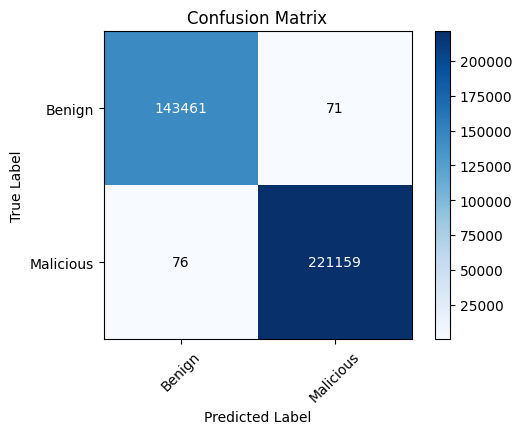

Classification Report:
               precision    recall  f1-score   support

      Benign   0.999505  0.999471  0.999488    143537
   Malicious   0.999656  0.999679  0.999668    221230

    accuracy                       0.999597    364767
   macro avg   0.999581  0.999575  0.999578    364767
weighted avg   0.999597  0.999597  0.999597    364767



In [11]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Get the unique categories in the target variable
target_categories = set(nidd_dataset[TARGET])

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=np.arange(len(target_categories)), labels=target_categories, rotation=45)
plt.yticks(ticks=np.arange(len(target_categories)), labels=target_categories)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()

# Generate and print the classification report
class_report = classification_report(predictions, y_test, target_names=target_categories, digits=6)
print("Classification Report:\n", class_report)

### Feature Importance Analysis and Decision Tree Visualization
***Tasks***:
- Extract feature importances from the trained model.
- Create a DataFrame to store feature names and their corresponding importances, sorted in descending order.
- Print the feature importances.
- Plot a bar chart for visualizing feature importances.

Feature Importances:
      Feature  Importance
4         Dir    0.472972
1      Offset    0.462853
3      AckDat    0.062086
8        dTtl    0.000587
9  sMeanPktSz    0.000572
0         Seq    0.000438
6       dIpId    0.000294
7      TcpRtt    0.000197
2        sTtl    0.000000
5   StartTime    0.000000


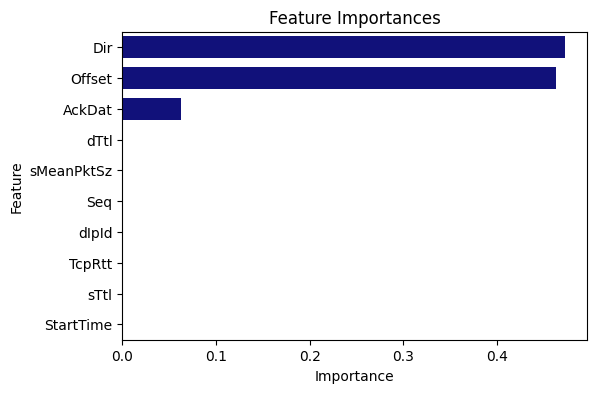

In [12]:
# Access the trained DecisionTreeClassifier from the pipeline
DTree = pipeline['classifier']

# Extract feature importances from the trained model
data = list(zip(top_10_features_cols, DTree.feature_importances_))
DTree_importances = pd.DataFrame(data, columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

# Print the feature importances
print("Feature Importances:")
print(DTree_importances)

# Plot a bar chart for visualizing feature importances
plt.figure(figsize=(6, 4))
sns.barplot(x='Importance', y='Feature', 
            data=DTree_importances,
            width=1.2, gap=0.4,
            color='#00008B')
plt.title('Feature Importances')
plt.show()

# Uncomment the following lines if you want to visualize the corresponding decision tree of Decision Tree Classifier
# fn = X_test.columns
# cn = pipeline['classifier'].classes_
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=800)
# tree.plot_tree(DTree.estimators_[0],
#                feature_names=fn,
#                class_names=cn,
#                filled=True)
# fig.savefig('DTree_tree.png')

### K-Fold Cross Validation for Model Evaluation
***Tasks***:
- Specify the number of folds for cross-validation (e.g. cv = 5).
- Define the scoring metrics for evaluation, including F1 score, Accuracy, Recall and Precision.
- Create a pipeline ('pipeline_cv') that includes preprocessing and DecisionTreeClassifier.
- Measure the time taken for cross-validation using the specified metrics.

In [13]:
# Number of folds for cross-validation
cv = 5

# Define the scoring metrics for evaluation
scoring = {'F1': make_scorer(f1_score, pos_label='Benign'), 
           'Accuracy': make_scorer(accuracy_score), 
           'Recall': make_scorer(recall_score, pos_label='Benign'),
           'Precision': make_scorer(precision_score, pos_label='Benign')}

# Create a pipeline with preprocessing and Decision Tree Classifier
pipeline_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Measure the time taken for cross-validation
t0 = time()
scores = cross_validate(pipeline_cv, nidd_dataset[top_10_features_cols], nidd_dataset[TARGET], 
                        cv=cv, scoring=scoring, return_train_score=True)
t1 = time()
preprocessing_d["Time <Cross validation>"] = t1 - t0

# Print the time taken for cross-validation
print(f"\nTime <Cross validation>: {preprocessing_d['Time <Cross validation>']:.3f} seconds")


Time <Cross validation>: 132.294 seconds


### Calculates overall mean scores and visualizes individual fold scores for each metric on both the training and testing sets.
***Tasks***:
- Print overall mean scores for each metric, including F1 Score, Accuracy, Recall and Precision.
- Plot individual cross-validation fold scores for each metric on both training and testing sets.
   - The x-axis represents the fold number.
   - Different colors distinguish between training and testing scores.

Overall F1 Results:
Mean Train F1: 1.0000
Mean Test F1: 0.8639
Overall Accuracy Results:
Mean Train Accuracy: 1.0000
Mean Test Accuracy: 0.9216
Overall Recall Results:
Mean Train Recall: 1.0000
Mean Test Recall: 0.8171
Overall Precision Results:
Mean Train Precision: 1.0000
Mean Test Precision: 0.9833


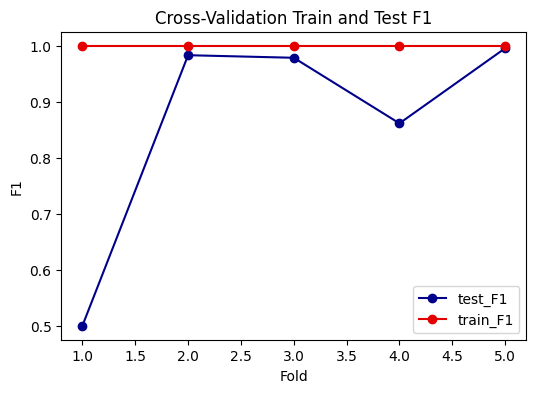

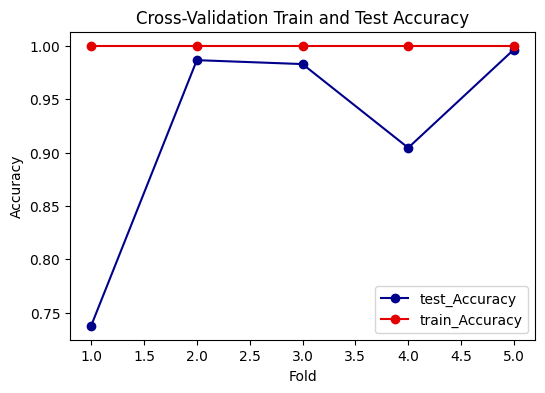

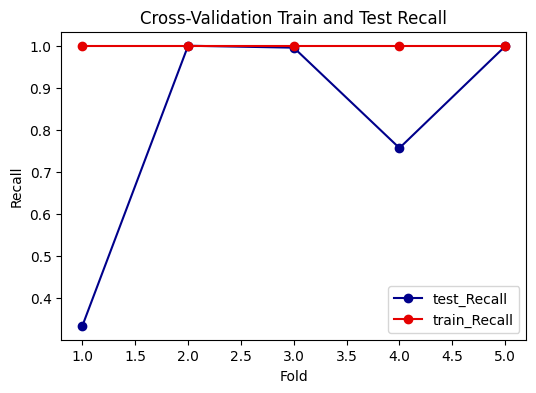

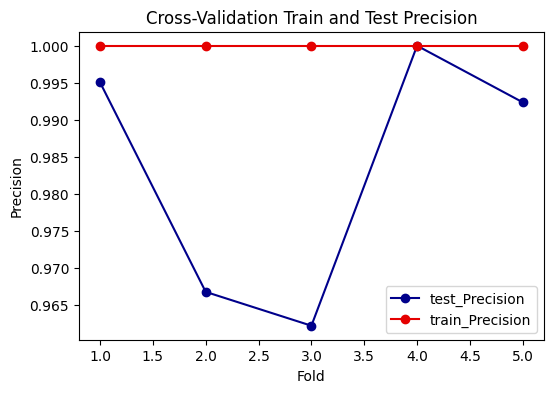

In [14]:
# Print overall mean scores for each metric
for metric in scoring.keys():
    mean_train_score = np.mean(scores[f'train_{metric}'])
    mean_test_score = np.mean(scores[f'test_{metric}'])
    print(f"Overall {metric} Results:")
    print(f"Mean Train {metric}: {mean_train_score:.4f}")
    print(f"Mean Test {metric}: {mean_test_score:.4f}")
    print("======================")

# Plot individual cross-validation fold scores for each metric
for metric in scoring.keys():
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, cv+1), scores[f'test_{metric}'], label=f'test_{metric}', marker='o', color='#00008B')
    plt.plot(range(1, cv+1), scores[f'train_{metric}'], label=f'train_{metric}', marker='o', color='#E50000')
    plt.title(f'Cross-Validation Train and Test {metric}')
    plt.xlabel('Fold')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

### Visualize the comparison to assess the model's consistency across cross-validation folds.

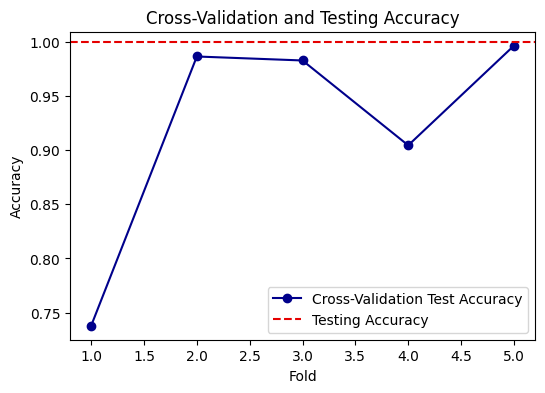

In [15]:
# Plot cross-validation test accuracy and a reference line for the testing accuracy of the model
plt.figure(figsize=(6, 4))
plt.plot(range(1, cv+1), scores[f'test_Accuracy'], label='Cross-Validation Test Accuracy', marker='o', color='#00008B')
plt.axhline(accuracy_score(y_test, predictions), linestyle='--', label='Testing Accuracy', color='#E50000')
plt.title('Cross-Validation and Testing Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Processing times for various preprocessing steps involved in the data preparation and model training pipeline

In [16]:
# Print the preprocessing times
print("Time Report:")
for key, time in preprocessing_d.items():
    print(f"{key}: {time:.4f} seconds")

Time Report:
Time <Dropping features based on a threshold `bad` values>: 2.6939 seconds
Time <Filling NaNs>: 2.5284 seconds
Time <Encoding categorical features>: 1.3361 seconds
Time <Feature selection>: 14.3386 seconds
Time <Model training>: 4.3780 seconds
Time <Model testing>: 0.4326 seconds
Time <Cross validation>: 132.2937 seconds
